In [ ]:
!pip install datasets accelerate matplotlib -U
!pip install torch torchvision pillow


In [ ]:
!pip install transformers

In [1]:
from transformers import VisionTextDualEncoderModel, VisionTextDualEncoderProcessor, AutoTokenizer, AutoImageProcessor
import torch
import torch.nn.functional as F

# Load the pre-trained models

tokenizer = AutoTokenizer.from_pretrained("google-bert/bert-base-uncased")
image_processor = AutoImageProcessor.from_pretrained("google/vit-base-patch16-224")
processor = VisionTextDualEncoderProcessor(image_processor, tokenizer)

/home/jrajan/micromamba/envs/visiondual/lib/python3.11/site-packages/torch/cuda/__init__.py:619: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
/home/jrajan/micromamba/envs/visiondual/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [29]:
###############################
##### Contrastive Dataset 
###############################
import os
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from transformers import VisionTextDualEncoderModel, VisionTextDualEncoderProcessor
from torch.optim import Adam
from torch.nn import functional as F
import torch
import random

# Mapping from class ID to class name
class_names = {
    0: 'DUMPSTER', 1: 'VEHICLE', 2: 'SKID_STEER', 3: 'EXCAVATOR', 4: 'VAN',
    5: 'LUMBER_BUNDLE', 6: 'CONE', 7: 'TRUCK', 8: 'GARBAGE_CONTAINER',
    9: 'LADDER', 10: 'POWER_GENERATOR', 11: 'TELESCOPIC_HANDLER',
    12: 'CONCRETE_BUCKET', 13: 'BOOMLIFT', 14: 'PLYWOOD', 15: 'TOILET_CABIN',
    16: 'FORMWORK_PROP_BUNDLE', 17: 'CONDUIT_ROLL', 18: 'FORMWORK_PANEL',
    19: 'CONCRETE_COLUMN', 20: 'PLATE_COMPACTOR', 21: 'TROWEL_POWER',
    22: 'SLAB_SLEEVES', 23: 'MINI_EXCAVATOR', 24: 'CONTAINER', 25: 'SCISSORLIFT',
    26: 'PICKUP_TRUCK', 27: 'MOBILE_CRANE', 28: 'EQUIPMENT', 29: 'TIEBACK_RIG',
    30: 'TOWER_CRANE', 31: 'CONCRETE_PUMP', 32: 'DRILLRIG', 33: 'LOADER',
    34: 'OFFICE_TRAILER', 35: 'DOZER', 36: 'BUS', 37: 'ROLLER', 38: 'CONCRETE_RIDE',
    39: 'BACKHOE_LOADER', 40: 'FORKLIFT', 41: 'GRADER', 42: 'HAND_ROLLER',
    43: 'HOIST_CABIN', 44: "UNKNOWN"
}

# def convert_to_words(text):
#     words = text.split('_')
#     lowercase_words = [word.lower() for word in words]
#     return ' '.join(lowercase_words)

class CustomDataset(Dataset):
    def __init__(self, image_dir, text_dir, processor, transform=None):
        self.image_dir = image_dir
        self.text_dir = text_dir
        self.transform = transform
        self.image_files = [f for f in os.listdir(image_dir) if f.endswith('.jpg') or f.endswith('.jpeg')]
        self.processor = processor

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        image_filename = self.image_files[idx]
        image_path = os.path.join(self.image_dir, image_filename)
        text_filename = os.path.splitext(image_filename)[0] + '.txt'
        text_path = os.path.join(self.text_dir, text_filename)

        image = Image.open(image_path).convert("RGB")
        if self.transform:
            image = self.transform(image)

        # Load and parse annotations
        with open(text_path, 'r') as file:
            annotations = file.readlines()
        
        parsed_annotations = [list(map(float, line.strip().split())) for line in annotations]

        # Find the annotation with the largest area
        caption_indices = [44]
        if len(parsed_annotations) > 0:
            parsed_annotations.sort(key=lambda x: x[3] * x[4], reverse=True)
            top_annotations = parsed_annotations[:5]
            caption_indices = [int(ann[0]) for ann in top_annotations]

        correct_captions = [class_names[idx] for idx in caption_indices]
        correct_caption = ' '.join(correct_captions)

        # Select a random incorrect caption
        incorrect_indices = list(set(class_names.keys()) - set(caption_indices))
        incorrect_captions = [class_names[random.choice(incorrect_indices)]]
        incorrect_caption = ' '.join(incorrect_captions)
        
        return correct_caption, incorrect_caption, image, image_path
    

# Define the image transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

image_dir = '/mnt/data/ypatel/ObjectDetection/Dataset/Dataset_D8/images/train'
text_dir = '/mnt/data/ypatel/ObjectDetection/Dataset/Dataset_D8/labels/train'

dataset = CustomDataset(image_dir=image_dir, text_dir=text_dir, transform=transform, processor=processor)

# To use with a DataLoader
from torch.utils.data import DataLoader

def custom_collate_fn(batch):
    correct_caption, incorrect_caption, image, image_path = zip(*batch)
    
    # Process the batch of images and captions
    correct_inputs = processor(text=correct_caption, images=list(image), return_tensors="pt", padding=True)
    incorrect_inputs = processor(text=incorrect_caption, images=list(image), return_tensors="pt", padding=True)

    return {
        "correct_input_ids": correct_inputs["input_ids"],
        "correct_attention_mask": correct_inputs["attention_mask"],
        "incorrect_input_ids": incorrect_inputs["input_ids"],
        "incorrect_attention_mask": incorrect_inputs["attention_mask"],
        "pixel_values": correct_inputs["pixel_values"]  # Same for both since images are the same
    }

dataloader = DataLoader(dataset, batch_size=32, collate_fn=custom_collate_fn)

# # Example of iterating through the dataset
for batch in dataloader:
    print(batch)
    break


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


{'correct_input_ids': tensor([[  101,  4654,  3540, 22879,  2953, 13044,  1035, 11661,   102,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0],
        [  101,  2433,  6198,  1035,  5997, 13891,  1035, 14012,  2433,  6198,
          1035,  5997, 10535, 11848,  1035,  6644,   102,     0,     0,     0,
             0,     0,     0,     0,     0],
        [  101, 11661, 11848,  1035,  6644, 20228, 26985, 20228, 26985, 10535,
           102,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0],
        [  101, 13044,  1035, 11661, 13171, 13171, 13171,   102,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0],
        [  101,  5509,  1035,  5930,  5509,  1035,  5930,  5509,  1035,  5930,
           102,     0,     0,     0,     0,     0,     0,     0,     0,     0,
        

In [30]:
dataset[150]

('TOWER_CRANE CONCRETE_PUMP FORMWORK_PANEL FORMWORK_PANEL LUMBER_BUNDLE',
 'CONDUIT_ROLL',
 tensor([[[0.8118, 0.8118, 0.8157,  ..., 0.8941, 0.8902, 0.8941],
          [0.8078, 0.8039, 0.8078,  ..., 0.9059, 0.9020, 0.8941],
          [0.8000, 0.8000, 0.8039,  ..., 0.9059, 0.8980, 0.8941],
          ...,
          [0.3137, 0.3059, 0.2863,  ..., 0.3569, 0.2588, 0.2902],
          [0.3373, 0.3176, 0.2980,  ..., 0.4471, 0.3098, 0.2863],
          [0.3333, 0.3216, 0.3098,  ..., 0.2745, 0.4667, 0.3373]],
 
         [[0.8392, 0.8392, 0.8431,  ..., 0.9216, 0.9176, 0.9176],
          [0.8353, 0.8314, 0.8353,  ..., 0.9333, 0.9294, 0.9176],
          [0.8275, 0.8275, 0.8314,  ..., 0.9373, 0.9294, 0.9176],
          ...,
          [0.3059, 0.2980, 0.2745,  ..., 0.3176, 0.2196, 0.2588],
          [0.3294, 0.3059, 0.2824,  ..., 0.4000, 0.2667, 0.2510],
          [0.3216, 0.3098, 0.2941,  ..., 0.2235, 0.4235, 0.2980]],
 
         [[0.8784, 0.8784, 0.8824,  ..., 0.9373, 0.9451, 0.9608],
          [0.87

In [2]:

# Define a simple training loop
from transformers import VisionTextDualEncoderModel, VisionTextDualEncoderProcessor, TrainingArguments, Trainer
import torch
import torch.nn.functional as F

# Load the pre-trained models
vision_model_name = "openai/clip-vit-base-patch32"
text_model_name = "bert-base-uncased"

model = model = VisionTextDualEncoderModel.from_vision_text_pretrained(
    "google/vit-base-patch16-224", "google-bert/bert-base-uncased"
)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")



/home/jrajan/micromamba/envs/visiondual/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
The projection layer and logit scale weights `['visual_projection.weight', 'text_projection.weight', 'logit_scale']` are newly initialized. You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [90]:
!export CUDA_LAUNCH_BLOCKING=1

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [91]:
###############################
##### Contrastive Training  
###############################
import torch
# Define a simple training loop
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#device = "cpu"
model.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5)

num_epochs = 2

for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    total_loss = 0

    for batch in dataloader:
        # Move inputs to the GPU if available
        correct_inputs = {
            "input_ids": batch["correct_input_ids"].to(device),
            "attention_mask": batch["correct_attention_mask"].to(device),
            "pixel_values": batch["pixel_values"].to(device)
        }
        incorrect_inputs = {
            "input_ids": batch["incorrect_input_ids"].to(device),
            "attention_mask": batch["incorrect_attention_mask"].to(device),
            "pixel_values": batch["pixel_values"].to(device)
        }
        # Forward pass for correct pairs
        correct_outputs = model(**correct_inputs)
        logits_per_image_correct = correct_outputs.logits_per_image
        logits_per_text_correct = correct_outputs.logits_per_text
        
        # Forward pass for incorrect pairs
        incorrect_outputs = model(**incorrect_inputs)
        logits_per_image_incorrect = incorrect_outputs.logits_per_image
        logits_per_text_incorrect = incorrect_outputs.logits_per_text

        # Contrastive loss
        labels = torch.arange(logits_per_image_correct.size(0)).to(device)
        loss_image_correct = F.cross_entropy(logits_per_image_correct, labels)
        loss_text_correct = F.cross_entropy(logits_per_text_correct, labels)
        loss_image_incorrect = F.cross_entropy(logits_per_image_incorrect, labels)
        loss_text_incorrect = F.cross_entropy(logits_per_text_incorrect, labels)

        loss = (loss_image_correct + loss_text_correct) / 2 - (loss_image_incorrect + loss_text_incorrect) / 2
        
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        print(loss)
        total_loss += loss.item()

    average_loss = total_loss / len(dataloader)
    print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {average_loss:.4f}")

print("Training complete.")

Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


tensor(0.0143, device='cuda:0', grad_fn=<SubBackward0>)


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


tensor(-0.0474, device='cuda:0', grad_fn=<SubBackward0>)


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


tensor(-0.7036, device='cuda:0', grad_fn=<SubBackward0>)


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


tensor(0.1810, device='cuda:0', grad_fn=<SubBackward0>)


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


tensor(-1.9924, device='cuda:0', grad_fn=<SubBackward0>)


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


tensor(-2.5933, device='cuda:0', grad_fn=<SubBackward0>)


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


tensor(-3.1880, device='cuda:0', grad_fn=<SubBackward0>)


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


tensor(-3.4192, device='cuda:0', grad_fn=<SubBackward0>)


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


tensor(-5.2165, device='cuda:0', grad_fn=<SubBackward0>)


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


tensor(-5.3353, device='cuda:0', grad_fn=<SubBackward0>)


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


tensor(-5.6120, device='cuda:0', grad_fn=<SubBackward0>)


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


tensor(-5.8067, device='cuda:0', grad_fn=<SubBackward0>)


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


tensor(-5.1876, device='cuda:0', grad_fn=<SubBackward0>)


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


tensor(-5.6579, device='cuda:0', grad_fn=<SubBackward0>)


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


tensor(-7.3459, device='cuda:0', grad_fn=<SubBackward0>)


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


tensor(-7.6202, device='cuda:0', grad_fn=<SubBackward0>)


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


tensor(-5.2125, device='cuda:0', grad_fn=<SubBackward0>)


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


tensor(-5.5564, device='cuda:0', grad_fn=<SubBackward0>)


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


tensor(-6.5730, device='cuda:0', grad_fn=<SubBackward0>)


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


tensor(-8.5123, device='cuda:0', grad_fn=<SubBackward0>)


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


tensor(-6.2145, device='cuda:0', grad_fn=<SubBackward0>)


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


tensor(-6.0453, device='cuda:0', grad_fn=<SubBackward0>)


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


tensor(-9.3097, device='cuda:0', grad_fn=<SubBackward0>)


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


tensor(-5.0377, device='cuda:0', grad_fn=<SubBackward0>)


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


tensor(-8.3434, device='cuda:0', grad_fn=<SubBackward0>)


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


tensor(-7.4741, device='cuda:0', grad_fn=<SubBackward0>)


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


tensor(-7.7352, device='cuda:0', grad_fn=<SubBackward0>)


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


tensor(-7.3176, device='cuda:0', grad_fn=<SubBackward0>)


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


tensor(-7.3534, device='cuda:0', grad_fn=<SubBackward0>)


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


tensor(-7.1674, device='cuda:0', grad_fn=<SubBackward0>)


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


tensor(-6.8154, device='cuda:0', grad_fn=<SubBackward0>)


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


tensor(-6.6745, device='cuda:0', grad_fn=<SubBackward0>)


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


tensor(-6.1248, device='cuda:0', grad_fn=<SubBackward0>)


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


tensor(-2.5184, device='cuda:0', grad_fn=<SubBackward0>)


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


tensor(-2.4113, device='cuda:0', grad_fn=<SubBackward0>)


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


tensor(-2.5529, device='cuda:0', grad_fn=<SubBackward0>)


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


tensor(-3.7386, device='cuda:0', grad_fn=<SubBackward0>)


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


tensor(-1.5987, device='cuda:0', grad_fn=<SubBackward0>)


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


tensor(7.3056, device='cuda:0', grad_fn=<SubBackward0>)


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


tensor(6.0311, device='cuda:0', grad_fn=<SubBackward0>)


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


tensor(-7.7159, device='cuda:0', grad_fn=<SubBackward0>)


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


tensor(-5.2505, device='cuda:0', grad_fn=<SubBackward0>)


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


tensor(-8.9738, device='cuda:0', grad_fn=<SubBackward0>)


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


tensor(-8.0203, device='cuda:0', grad_fn=<SubBackward0>)


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


tensor(-7.6067, device='cuda:0', grad_fn=<SubBackward0>)


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


tensor(-8.6925, device='cuda:0', grad_fn=<SubBackward0>)


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


tensor(-9.7768, device='cuda:0', grad_fn=<SubBackward0>)


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


tensor(-8.9548, device='cuda:0', grad_fn=<SubBackward0>)


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


tensor(-7.3126, device='cuda:0', grad_fn=<SubBackward0>)


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


tensor(-11.3776, device='cuda:0', grad_fn=<SubBackward0>)


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


tensor(-8.9493, device='cuda:0', grad_fn=<SubBackward0>)


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


tensor(-9.4299, device='cuda:0', grad_fn=<SubBackward0>)


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


tensor(-8.4521, device='cuda:0', grad_fn=<SubBackward0>)


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


tensor(-7.4644, device='cuda:0', grad_fn=<SubBackward0>)


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


tensor(-8.5300, device='cuda:0', grad_fn=<SubBackward0>)


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


tensor(-6.9158, device='cuda:0', grad_fn=<SubBackward0>)


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


tensor(-9.3182, device='cuda:0', grad_fn=<SubBackward0>)


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


tensor(-7.2088, device='cuda:0', grad_fn=<SubBackward0>)


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


tensor(-6.3234, device='cuda:0', grad_fn=<SubBackward0>)


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


tensor(-6.2252, device='cuda:0', grad_fn=<SubBackward0>)


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


tensor(-7.5638, device='cuda:0', grad_fn=<SubBackward0>)


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


tensor(-5.4327, device='cuda:0', grad_fn=<SubBackward0>)


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


tensor(-5.9670, device='cuda:0', grad_fn=<SubBackward0>)


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


tensor(-7.8101, device='cuda:0', grad_fn=<SubBackward0>)


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


tensor(-5.5110, device='cuda:0', grad_fn=<SubBackward0>)


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


tensor(-5.8208, device='cuda:0', grad_fn=<SubBackward0>)


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


tensor(-9.9240, device='cuda:0', grad_fn=<SubBackward0>)


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


tensor(-9.7549, device='cuda:0', grad_fn=<SubBackward0>)


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


tensor(-9.1499, device='cuda:0', grad_fn=<SubBackward0>)


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


tensor(-8.2925, device='cuda:0', grad_fn=<SubBackward0>)


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


tensor(-9.1296, device='cuda:0', grad_fn=<SubBackward0>)


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


tensor(-9.1200, device='cuda:0', grad_fn=<SubBackward0>)


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


tensor(-10.1443, device='cuda:0', grad_fn=<SubBackward0>)


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


tensor(-9.4068, device='cuda:0', grad_fn=<SubBackward0>)


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


tensor(-8.1612, device='cuda:0', grad_fn=<SubBackward0>)


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


tensor(-9.5444, device='cuda:0', grad_fn=<SubBackward0>)


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


tensor(-8.2263, device='cuda:0', grad_fn=<SubBackward0>)


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


tensor(-7.6279, device='cuda:0', grad_fn=<SubBackward0>)


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


tensor(-5.9486, device='cuda:0', grad_fn=<SubBackward0>)


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


tensor(-6.0704, device='cuda:0', grad_fn=<SubBackward0>)


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


tensor(-8.9317, device='cuda:0', grad_fn=<SubBackward0>)


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


tensor(-5.8992, device='cuda:0', grad_fn=<SubBackward0>)


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


tensor(-8.9736, device='cuda:0', grad_fn=<SubBackward0>)


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


tensor(-9.0440, device='cuda:0', grad_fn=<SubBackward0>)


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


tensor(-6.9101, device='cuda:0', grad_fn=<SubBackward0>)


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


tensor(-6.4586, device='cuda:0', grad_fn=<SubBackward0>)


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


tensor(-8.1166, device='cuda:0', grad_fn=<SubBackward0>)


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


tensor(-7.8472, device='cuda:0', grad_fn=<SubBackward0>)


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


tensor(-7.8194, device='cuda:0', grad_fn=<SubBackward0>)


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


tensor(-10.8833, device='cuda:0', grad_fn=<SubBackward0>)


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


tensor(-9.4523, device='cuda:0', grad_fn=<SubBackward0>)


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


tensor(-10.5954, device='cuda:0', grad_fn=<SubBackward0>)


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


tensor(-9.6218, device='cuda:0', grad_fn=<SubBackward0>)


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


tensor(-4.9787, device='cuda:0', grad_fn=<SubBackward0>)


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


tensor(-3.5472, device='cuda:0', grad_fn=<SubBackward0>)


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


tensor(-8.3905, device='cuda:0', grad_fn=<SubBackward0>)


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


tensor(-4.2765, device='cuda:0', grad_fn=<SubBackward0>)


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


tensor(-8.8369, device='cuda:0', grad_fn=<SubBackward0>)


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


tensor(-8.4200, device='cuda:0', grad_fn=<SubBackward0>)


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


tensor(-7.9914, device='cuda:0', grad_fn=<SubBackward0>)


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


tensor(-8.2617, device='cuda:0', grad_fn=<SubBackward0>)


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


tensor(-9.2090, device='cuda:0', grad_fn=<SubBackward0>)


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


tensor(-10.7609, device='cuda:0', grad_fn=<SubBackward0>)


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


tensor(-9.2045, device='cuda:0', grad_fn=<SubBackward0>)


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


tensor(-11.0396, device='cuda:0', grad_fn=<SubBackward0>)


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


tensor(-8.7938, device='cuda:0', grad_fn=<SubBackward0>)


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


tensor(-9.8598, device='cuda:0', grad_fn=<SubBackward0>)


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


tensor(-10.3122, device='cuda:0', grad_fn=<SubBackward0>)


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


tensor(-7.3585, device='cuda:0', grad_fn=<SubBackward0>)


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


tensor(-11.4909, device='cuda:0', grad_fn=<SubBackward0>)


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


tensor(-10.9237, device='cuda:0', grad_fn=<SubBackward0>)


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


tensor(-10.1871, device='cuda:0', grad_fn=<SubBackward0>)


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


tensor(-9.3931, device='cuda:0', grad_fn=<SubBackward0>)


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


tensor(-9.9911, device='cuda:0', grad_fn=<SubBackward0>)


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


tensor(-9.4783, device='cuda:0', grad_fn=<SubBackward0>)


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


tensor(-10.3948, device='cuda:0', grad_fn=<SubBackward0>)


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


tensor(-10.4270, device='cuda:0', grad_fn=<SubBackward0>)


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


tensor(-9.2612, device='cuda:0', grad_fn=<SubBackward0>)


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


tensor(-7.9554, device='cuda:0', grad_fn=<SubBackward0>)


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


tensor(-6.8228, device='cuda:0', grad_fn=<SubBackward0>)


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


tensor(-6.3130, device='cuda:0', grad_fn=<SubBackward0>)


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


tensor(-6.7911, device='cuda:0', grad_fn=<SubBackward0>)


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


tensor(-8.3974, device='cuda:0', grad_fn=<SubBackward0>)


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


tensor(-9.2699, device='cuda:0', grad_fn=<SubBackward0>)


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


tensor(-10.3279, device='cuda:0', grad_fn=<SubBackward0>)


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


tensor(-8.3374, device='cuda:0', grad_fn=<SubBackward0>)


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


tensor(-7.9916, device='cuda:0', grad_fn=<SubBackward0>)


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


tensor(-9.8156, device='cuda:0', grad_fn=<SubBackward0>)


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


tensor(-8.5731, device='cuda:0', grad_fn=<SubBackward0>)


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


tensor(-8.6725, device='cuda:0', grad_fn=<SubBackward0>)


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


tensor(-9.7555, device='cuda:0', grad_fn=<SubBackward0>)


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


tensor(-10.6962, device='cuda:0', grad_fn=<SubBackward0>)


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


tensor(2.8436, device='cuda:0', grad_fn=<SubBackward0>)


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


tensor(-9.5715, device='cuda:0', grad_fn=<SubBackward0>)


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


tensor(2.1610, device='cuda:0', grad_fn=<SubBackward0>)


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


tensor(-10.0082, device='cuda:0', grad_fn=<SubBackward0>)


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


tensor(-9.4607, device='cuda:0', grad_fn=<SubBackward0>)


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


tensor(-10.0477, device='cuda:0', grad_fn=<SubBackward0>)


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


tensor(-11.0175, device='cuda:0', grad_fn=<SubBackward0>)


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


tensor(-9.4784, device='cuda:0', grad_fn=<SubBackward0>)


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


tensor(-9.1461, device='cuda:0', grad_fn=<SubBackward0>)


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


tensor(-9.3932, device='cuda:0', grad_fn=<SubBackward0>)


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


tensor(-7.5970, device='cuda:0', grad_fn=<SubBackward0>)


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


tensor(-7.0994, device='cuda:0', grad_fn=<SubBackward0>)


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


tensor(-6.7001, device='cuda:0', grad_fn=<SubBackward0>)


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


tensor(-5.9692, device='cuda:0', grad_fn=<SubBackward0>)


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


tensor(-5.5158, device='cuda:0', grad_fn=<SubBackward0>)


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


tensor(-6.6456, device='cuda:0', grad_fn=<SubBackward0>)


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


tensor(-6.3743, device='cuda:0', grad_fn=<SubBackward0>)


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


tensor(-5.3987, device='cuda:0', grad_fn=<SubBackward0>)


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


tensor(-5.1144, device='cuda:0', grad_fn=<SubBackward0>)


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


tensor(-6.3808, device='cuda:0', grad_fn=<SubBackward0>)


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


tensor(-8.0619, device='cuda:0', grad_fn=<SubBackward0>)


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


tensor(-8.9661, device='cuda:0', grad_fn=<SubBackward0>)


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


tensor(-9.2043, device='cuda:0', grad_fn=<SubBackward0>)


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


tensor(-5.1301, device='cuda:0', grad_fn=<SubBackward0>)


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


tensor(-8.8949, device='cuda:0', grad_fn=<SubBackward0>)


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


tensor(-6.3882, device='cuda:0', grad_fn=<SubBackward0>)


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


tensor(-8.9403, device='cuda:0', grad_fn=<SubBackward0>)


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


tensor(-9.8045, device='cuda:0', grad_fn=<SubBackward0>)
Epoch [1/2], Loss: -7.1997


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


tensor(-7.2382, device='cuda:0', grad_fn=<SubBackward0>)


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


tensor(-8.4314, device='cuda:0', grad_fn=<SubBackward0>)


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


tensor(-8.8284, device='cuda:0', grad_fn=<SubBackward0>)


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


tensor(-8.7643, device='cuda:0', grad_fn=<SubBackward0>)


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


tensor(-9.5509, device='cuda:0', grad_fn=<SubBackward0>)


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


tensor(-8.0368, device='cuda:0', grad_fn=<SubBackward0>)


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


tensor(-10.6741, device='cuda:0', grad_fn=<SubBackward0>)


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


tensor(-7.5744, device='cuda:0', grad_fn=<SubBackward0>)


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


tensor(-9.9067, device='cuda:0', grad_fn=<SubBackward0>)


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


tensor(-9.5705, device='cuda:0', grad_fn=<SubBackward0>)


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


tensor(-7.8283, device='cuda:0', grad_fn=<SubBackward0>)


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


tensor(-8.6171, device='cuda:0', grad_fn=<SubBackward0>)


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


tensor(-6.3394, device='cuda:0', grad_fn=<SubBackward0>)


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


tensor(-8.9495, device='cuda:0', grad_fn=<SubBackward0>)


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


tensor(-9.5637, device='cuda:0', grad_fn=<SubBackward0>)


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


tensor(-9.6168, device='cuda:0', grad_fn=<SubBackward0>)


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


tensor(-9.1122, device='cuda:0', grad_fn=<SubBackward0>)


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


tensor(-10.2544, device='cuda:0', grad_fn=<SubBackward0>)


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


tensor(-8.8036, device='cuda:0', grad_fn=<SubBackward0>)


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


tensor(-10.4262, device='cuda:0', grad_fn=<SubBackward0>)


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


tensor(-10.6876, device='cuda:0', grad_fn=<SubBackward0>)


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


tensor(-9.1106, device='cuda:0', grad_fn=<SubBackward0>)


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


tensor(-9.2644, device='cuda:0', grad_fn=<SubBackward0>)


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


tensor(-10.2579, device='cuda:0', grad_fn=<SubBackward0>)


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


tensor(-7.5507, device='cuda:0', grad_fn=<SubBackward0>)


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


tensor(-8.0772, device='cuda:0', grad_fn=<SubBackward0>)


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


tensor(-7.9464, device='cuda:0', grad_fn=<SubBackward0>)


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


tensor(-10.8663, device='cuda:0', grad_fn=<SubBackward0>)


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


tensor(-9.2438, device='cuda:0', grad_fn=<SubBackward0>)


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


tensor(-9.9238, device='cuda:0', grad_fn=<SubBackward0>)


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


tensor(-9.2450, device='cuda:0', grad_fn=<SubBackward0>)


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


tensor(-9.2448, device='cuda:0', grad_fn=<SubBackward0>)


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


tensor(-8.8912, device='cuda:0', grad_fn=<SubBackward0>)


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


tensor(-8.4214, device='cuda:0', grad_fn=<SubBackward0>)


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


tensor(-10.4381, device='cuda:0', grad_fn=<SubBackward0>)


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


tensor(-9.6303, device='cuda:0', grad_fn=<SubBackward0>)


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


tensor(-9.9303, device='cuda:0', grad_fn=<SubBackward0>)


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


tensor(-8.9039, device='cuda:0', grad_fn=<SubBackward0>)


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


tensor(-10.8010, device='cuda:0', grad_fn=<SubBackward0>)


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


tensor(-8.4616, device='cuda:0', grad_fn=<SubBackward0>)


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


tensor(-10.0698, device='cuda:0', grad_fn=<SubBackward0>)


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


tensor(-10.0398, device='cuda:0', grad_fn=<SubBackward0>)


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


tensor(-10.5019, device='cuda:0', grad_fn=<SubBackward0>)


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


tensor(-8.4941, device='cuda:0', grad_fn=<SubBackward0>)


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


tensor(-9.2028, device='cuda:0', grad_fn=<SubBackward0>)


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


tensor(-10.4472, device='cuda:0', grad_fn=<SubBackward0>)


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


tensor(-10.8060, device='cuda:0', grad_fn=<SubBackward0>)


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


tensor(-10.8828, device='cuda:0', grad_fn=<SubBackward0>)


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


tensor(-7.1332, device='cuda:0', grad_fn=<SubBackward0>)


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


tensor(-7.7028, device='cuda:0', grad_fn=<SubBackward0>)


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


tensor(-9.6929, device='cuda:0', grad_fn=<SubBackward0>)


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


tensor(-8.9004, device='cuda:0', grad_fn=<SubBackward0>)


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


tensor(-9.5805, device='cuda:0', grad_fn=<SubBackward0>)


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


tensor(-9.2108, device='cuda:0', grad_fn=<SubBackward0>)


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


tensor(-10.5142, device='cuda:0', grad_fn=<SubBackward0>)


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


tensor(-10.0787, device='cuda:0', grad_fn=<SubBackward0>)


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


tensor(-9.3409, device='cuda:0', grad_fn=<SubBackward0>)


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


tensor(-10.4540, device='cuda:0', grad_fn=<SubBackward0>)


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


tensor(-8.8296, device='cuda:0', grad_fn=<SubBackward0>)


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


tensor(-10.0831, device='cuda:0', grad_fn=<SubBackward0>)


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


tensor(-9.3068, device='cuda:0', grad_fn=<SubBackward0>)


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


tensor(-10.5184, device='cuda:0', grad_fn=<SubBackward0>)


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


tensor(-9.6486, device='cuda:0', grad_fn=<SubBackward0>)


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


tensor(-8.8724, device='cuda:0', grad_fn=<SubBackward0>)


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


tensor(-10.0251, device='cuda:0', grad_fn=<SubBackward0>)


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


tensor(-10.3845, device='cuda:0', grad_fn=<SubBackward0>)


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


tensor(-10.8966, device='cuda:0', grad_fn=<SubBackward0>)


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


tensor(-10.8222, device='cuda:0', grad_fn=<SubBackward0>)


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


tensor(-10.0870, device='cuda:0', grad_fn=<SubBackward0>)


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


tensor(-8.8333, device='cuda:0', grad_fn=<SubBackward0>)


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


tensor(-10.8237, device='cuda:0', grad_fn=<SubBackward0>)


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


tensor(-8.5102, device='cuda:0', grad_fn=<SubBackward0>)


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


tensor(-7.6670, device='cuda:0', grad_fn=<SubBackward0>)


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


tensor(-8.0763, device='cuda:0', grad_fn=<SubBackward0>)


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


tensor(-10.0314, device='cuda:0', grad_fn=<SubBackward0>)


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


tensor(-10.0934, device='cuda:0', grad_fn=<SubBackward0>)


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


tensor(-11.9114, device='cuda:0', grad_fn=<SubBackward0>)


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


tensor(-7.6940, device='cuda:0', grad_fn=<SubBackward0>)


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


tensor(-8.0124, device='cuda:0', grad_fn=<SubBackward0>)


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


tensor(-10.3942, device='cuda:0', grad_fn=<SubBackward0>)


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


tensor(-10.5330, device='cuda:0', grad_fn=<SubBackward0>)


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


tensor(-9.2762, device='cuda:0', grad_fn=<SubBackward0>)


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


tensor(-8.5150, device='cuda:0', grad_fn=<SubBackward0>)


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


tensor(-10.3982, device='cuda:0', grad_fn=<SubBackward0>)


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


tensor(-8.8841, device='cuda:0', grad_fn=<SubBackward0>)


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


tensor(-10.9098, device='cuda:0', grad_fn=<SubBackward0>)


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


tensor(-10.0995, device='cuda:0', grad_fn=<SubBackward0>)


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


tensor(-5.9962, device='cuda:0', grad_fn=<SubBackward0>)


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


tensor(-10.1504, device='cuda:0', grad_fn=<SubBackward0>)


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


tensor(-8.1353, device='cuda:0', grad_fn=<SubBackward0>)


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


tensor(-10.5366, device='cuda:0', grad_fn=<SubBackward0>)


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


tensor(-10.1536, device='cuda:0', grad_fn=<SubBackward0>)


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


tensor(-10.1026, device='cuda:0', grad_fn=<SubBackward0>)


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


tensor(-8.8477, device='cuda:0', grad_fn=<SubBackward0>)


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


tensor(-9.7629, device='cuda:0', grad_fn=<SubBackward0>)


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


tensor(-8.4908, device='cuda:0', grad_fn=<SubBackward0>)


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


tensor(-8.9599, device='cuda:0', grad_fn=<SubBackward0>)


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


tensor(-10.5424, device='cuda:0', grad_fn=<SubBackward0>)


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


tensor(-9.3299, device='cuda:0', grad_fn=<SubBackward0>)


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


tensor(-9.7646, device='cuda:0', grad_fn=<SubBackward0>)


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


tensor(-9.7231, device='cuda:0', grad_fn=<SubBackward0>)


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


tensor(-9.6726, device='cuda:0', grad_fn=<SubBackward0>)


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


tensor(-9.7670, device='cuda:0', grad_fn=<SubBackward0>)


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


tensor(-10.4775, device='cuda:0', grad_fn=<SubBackward0>)


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


tensor(-9.7247, device='cuda:0', grad_fn=<SubBackward0>)


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


tensor(-8.4957, device='cuda:0', grad_fn=<SubBackward0>)


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


tensor(-10.4109, device='cuda:0', grad_fn=<SubBackward0>)


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


tensor(-8.0627, device='cuda:0', grad_fn=<SubBackward0>)


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


tensor(-7.2491, device='cuda:0', grad_fn=<SubBackward0>)


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


tensor(-10.1627, device='cuda:0', grad_fn=<SubBackward0>)


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


tensor(-10.4145, device='cuda:0', grad_fn=<SubBackward0>)


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


tensor(-10.0529, device='cuda:0', grad_fn=<SubBackward0>)


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


tensor(-8.0943, device='cuda:0', grad_fn=<SubBackward0>)


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


tensor(-9.6812, device='cuda:0', grad_fn=<SubBackward0>)


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


tensor(-9.2458, device='cuda:0', grad_fn=<SubBackward0>)


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


tensor(-8.9383, device='cuda:0', grad_fn=<SubBackward0>)


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


tensor(-11.6330, device='cuda:0', grad_fn=<SubBackward0>)


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


tensor(-8.9390, device='cuda:0', grad_fn=<SubBackward0>)


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


tensor(-10.1193, device='cuda:0', grad_fn=<SubBackward0>)


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


tensor(-9.3398, device='cuda:0', grad_fn=<SubBackward0>)


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


tensor(-8.0997, device='cuda:0', grad_fn=<SubBackward0>)


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


tensor(-8.4273, device='cuda:0', grad_fn=<SubBackward0>)


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


tensor(-8.8618, device='cuda:0', grad_fn=<SubBackward0>)


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


tensor(-9.7770, device='cuda:0', grad_fn=<SubBackward0>)


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


tensor(-9.3797, device='cuda:0', grad_fn=<SubBackward0>)


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


tensor(-10.4996, device='cuda:0', grad_fn=<SubBackward0>)


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


tensor(-8.8652, device='cuda:0', grad_fn=<SubBackward0>)


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


tensor(-8.9079, device='cuda:0', grad_fn=<SubBackward0>)


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


tensor(-10.9369, device='cuda:0', grad_fn=<SubBackward0>)


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


tensor(-8.4734, device='cuda:0', grad_fn=<SubBackward0>)


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


tensor(-8.8157, device='cuda:0', grad_fn=<SubBackward0>)


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


tensor(-7.7389, device='cuda:0', grad_fn=<SubBackward0>)


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


tensor(-10.1268, device='cuda:0', grad_fn=<SubBackward0>)


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


tensor(-9.7417, device='cuda:0', grad_fn=<SubBackward0>)


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


tensor(-10.7728, device='cuda:0', grad_fn=<SubBackward0>)


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


tensor(-8.4376, device='cuda:0', grad_fn=<SubBackward0>)


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


tensor(-10.5057, device='cuda:0', grad_fn=<SubBackward0>)


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


tensor(-8.9128, device='cuda:0', grad_fn=<SubBackward0>)


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


tensor(-10.4258, device='cuda:0', grad_fn=<SubBackward0>)


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


tensor(-11.3061, device='cuda:0', grad_fn=<SubBackward0>)


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


tensor(-8.5143, device='cuda:0', grad_fn=<SubBackward0>)


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


tensor(-10.8704, device='cuda:0', grad_fn=<SubBackward0>)


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


tensor(-11.0863, device='cuda:0', grad_fn=<SubBackward0>)


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


tensor(-11.3100, device='cuda:0', grad_fn=<SubBackward0>)


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


tensor(-11.2141, device='cuda:0', grad_fn=<SubBackward0>)


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


tensor(-10.7788, device='cuda:0', grad_fn=<SubBackward0>)


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


tensor(-11.9630, device='cuda:0', grad_fn=<SubBackward0>)


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


tensor(-8.1391, device='cuda:0', grad_fn=<SubBackward0>)


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


tensor(-10.5133, device='cuda:0', grad_fn=<SubBackward0>)


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


tensor(-10.1369, device='cuda:0', grad_fn=<SubBackward0>)


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


tensor(-6.8535, device='cuda:0', grad_fn=<SubBackward0>)


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


tensor(-10.1385, device='cuda:0', grad_fn=<SubBackward0>)


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


tensor(-10.9530, device='cuda:0', grad_fn=<SubBackward0>)


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


tensor(-8.5208, device='cuda:0', grad_fn=<SubBackward0>)


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


tensor(-9.7543, device='cuda:0', grad_fn=<SubBackward0>)


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


tensor(-8.9224, device='cuda:0', grad_fn=<SubBackward0>)


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


tensor(-11.9675, device='cuda:0', grad_fn=<SubBackward0>)


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


tensor(-9.7048, device='cuda:0', grad_fn=<SubBackward0>)


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


tensor(-10.9576, device='cuda:0', grad_fn=<SubBackward0>)


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


tensor(-11.0213, device='cuda:0', grad_fn=<SubBackward0>)
Epoch [2/2], Loss: -9.5093
Training complete.


In [92]:
model.save_pretrained("./vit-bert")
processor.save_pretrained("./vit-bert")

[]

In [21]:
model

VisionTextDualEncoderModel(
  (vision_model): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_

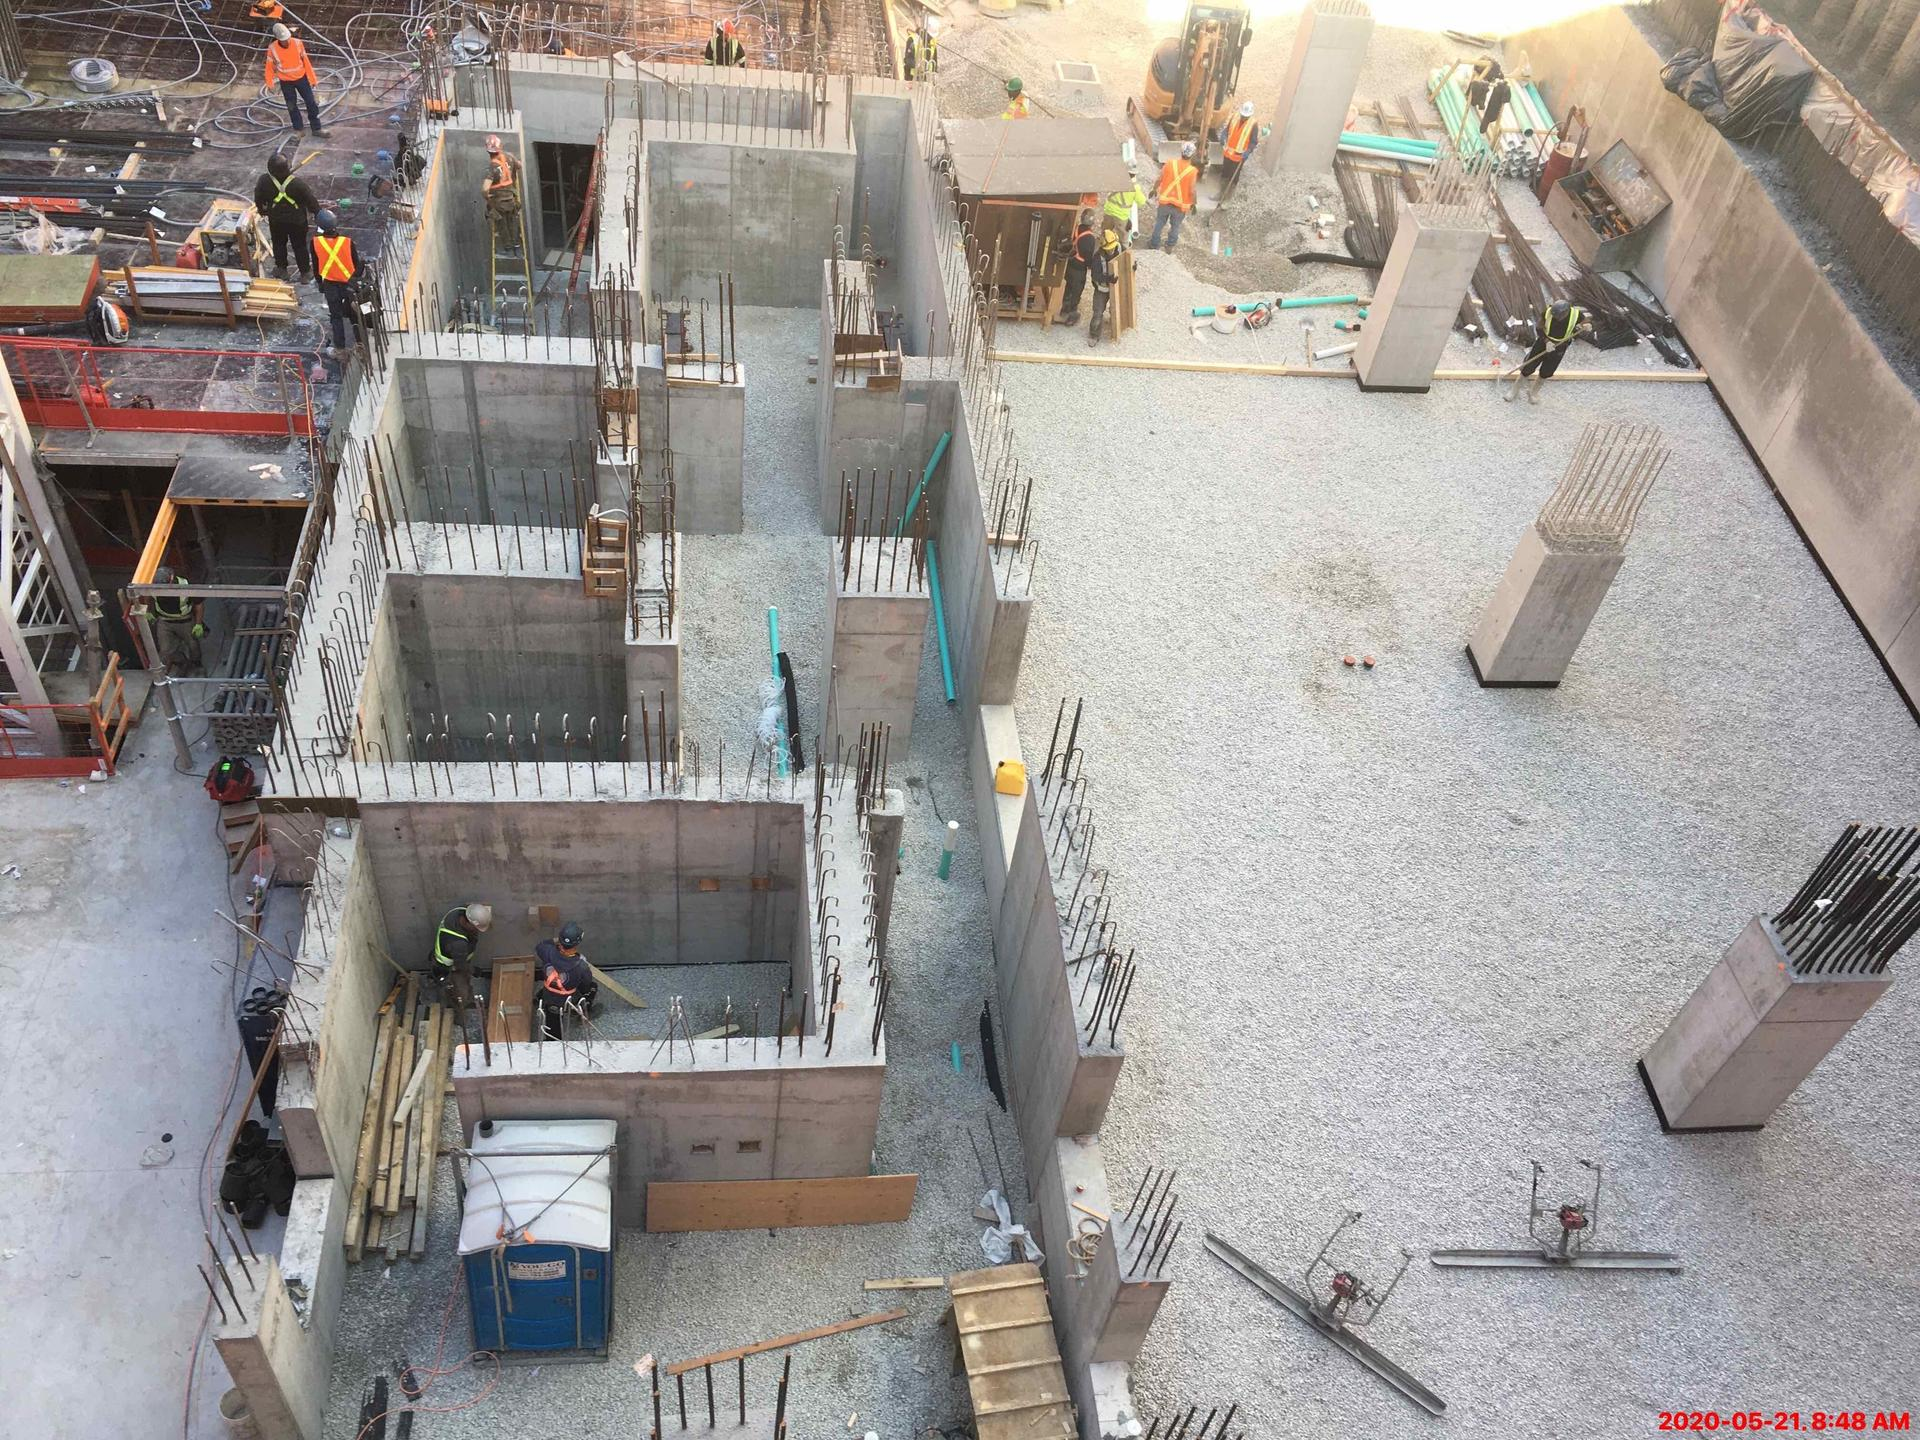

In [19]:
image_path = '/mnt/data/ypatel/ObjectDetection/Dataset/Dataset_D8/images/val/2018-11-22 11.02.10.jpg'
image_path = '/mnt/data/ypatel/ObjectDetection/Dataset/Dataset_D8/images/val/01_4A799364-FADA-4722-BC9C-59D4C913B168.jpeg'
image = Image.open(image_path).convert("RGB")
image

In [22]:
###############################
#### Inference with Contrastive 
###############################
from transformers import VisionTextDualEncoderModel, BertTokenizer
from PIL import Image
import torch 
from torchvision import transforms

# Load the saved model and processor
model = VisionTextDualEncoderModel.from_pretrained("./vit-bert")
processor = VisionTextDualEncoderProcessor.from_pretrained("./vit-bert")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#device = "cpu"
model.to(device)
model.eval()

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

# Define a function for inference
def predict(image_path, captions):
    # Preprocess the image
    image = Image.open(image_path).convert("RGB")
    inputs = processor(text=captions, images=[image], return_tensors="pt", padding=True)

    input_ids = inputs.input_ids.to(device)
    attention_mask = inputs.attention_mask.to(device)
    pixes_values = inputs.pixel_values.to(device)

    with torch.no_grad():
        outputs = model(pixel_values=pixes_values, input_ids=input_ids, attention_mask=attention_mask)
        logits_per_image = outputs.logits_per_image
        logits_per_text = outputs.logits_per_text

    return logits_per_image, logits_per_text

# Example usage
#image_path = '/mnt/data/ypatel/ObjectDetection/Dataset/Dataset_D8/images/val/20210325175112_production_2746262081.jpeg'
#image_path = '/mnt/data/ypatel/ObjectDetection/Dataset/Dataset_D8/images/train/01_002AFA69-A930-41C6-8982-20000E50EF97.jpeg'
captions = list(class_names.values())

logits_per_image, logits_per_text = predict(image_path, captions)
correct_probs = F.softmax(logits_per_image, dim=-1)
print(logits_per_image)
#correct_label = torch.argmax(correct_probs, dim=-1).item()
correct_label_indices =torch.topk(correct_probs, 5).indices.squeeze().tolist()
correct_classes = [class_names[i] for i in correct_label_indices]

print(correct_classes)


Unused or unrecognized kwargs: padding.


tensor([[ 1.3746, -1.3887,  1.3800,  1.3880, -1.3914, -1.4061, -1.3917, -1.3893,
         -1.3929,  1.3757, -1.4160,  1.3757, -1.4083,  1.3791, -1.3899, -1.4133,
          1.3742, -1.3902,  1.3769, -1.4069, -1.3915, -1.3911, -1.4101,  1.3883,
         -1.3487, -1.3819, -1.4030, -1.4090, -1.3823, -1.3923, -1.4102, -1.4105,
         -1.4010, -1.3926, -1.4026, -1.3975, -1.3946, -1.4033, -1.4054, -1.3854,
          1.3738, -1.4023, -1.3986, -1.4006,  1.3939]], device='cuda:0')
['UNKNOWN', 'MINI_EXCAVATOR', 'EXCAVATOR', 'SKID_STEER', 'BOOMLIFT']


In [23]:
torch.topk(correct_probs, 5).indices.squeeze().tolist()

[44, 23, 3, 2, 13]

In [31]:
#################################
### Calculate Accuracy
#################################
from tqdm.notebook import tqdm

def extract_top(scores, n):
    sorted_scores = sorted(scores.items(), key=lambda x: x[1], reverse=True)
    top_n = sorted_scores[:n]
    captions = [cap[0] for cap in top_n]
    return captions

matched = 0
total = 200
for i in range(total):
    original_captions = dataset[i][0]
    image_path = dataset[i][3]
    image = Image.open(image_path)
    
    captions = list(class_names.values())

    logits_per_image, logits_per_text = predict(image_path, captions)
    correct_probs = F.softmax(logits_per_image, dim=-1)
    #correct_label = torch.argmax(correct_probs, dim=-1).item()
    correct_label_indices =torch.topk(correct_probs, 5).indices.squeeze().tolist()
    correct_classes = [class_names[i] for i in correct_label_indices]
    
    
    for clazz in correct_classes:
        if clazz in original_captions: 
            matched += 1
    
    print(f"original: {original_captions} vs predicted {correct_classes}")
    
accuracy = matched/total
    

Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


original: EXCAVATOR GARBAGE_CONTAINER vs predicted ['EXCAVATOR', 'MINI_EXCAVATOR', 'FORMWORK_PROP_BUNDLE', 'FORMWORK_PANEL', 'UNKNOWN']
original: FORMWORK_PANEL LUMBER_BUNDLE FORMWORK_PANEL LADDER TOILET_CABIN vs predicted ['UNKNOWN', 'SKID_STEER', 'EXCAVATOR', 'BOOMLIFT', 'MINI_EXCAVATOR']


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


original: CONTAINER TOILET_CABIN PLYWOOD PLYWOOD LADDER vs predicted ['UNKNOWN', 'MINI_EXCAVATOR', 'BOOMLIFT', 'EXCAVATOR', 'SKID_STEER']
original: GARBAGE_CONTAINER CONE CONE CONE vs predicted ['TELESCOPIC_HANDLER', 'LADDER', 'SKID_STEER', 'EXCAVATOR', 'MINI_EXCAVATOR']
original: CONCRETE_COLUMN CONCRETE_COLUMN CONCRETE_COLUMN vs predicted ['PLATE_COMPACTOR', 'BACKHOE_LOADER', 'GARBAGE_CONTAINER', 'PICKUP_TRUCK', 'SCISSORLIFT']


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


original: CONCRETE_PUMP FORMWORK_PANEL BOOMLIFT FORMWORK_PANEL BOOMLIFT vs predicted ['UNKNOWN', 'BOOMLIFT', 'FORMWORK_PANEL', 'FORMWORK_PROP_BUNDLE', 'FORKLIFT']
original: TELESCOPIC_HANDLER EXCAVATOR TIEBACK_RIG CONDUIT_ROLL CONDUIT_ROLL vs predicted ['UNKNOWN', 'EXCAVATOR', 'MINI_EXCAVATOR', 'FORMWORK_PROP_BUNDLE', 'SKID_STEER']


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


original: LUMBER_BUNDLE LUMBER_BUNDLE vs predicted ['UNKNOWN', 'EXCAVATOR', 'LADDER', 'MINI_EXCAVATOR', 'SKID_STEER']
original: CONCRETE_PUMP FORMWORK_PANEL TOWER_CRANE CONCRETE_COLUMN TOILET_CABIN vs predicted ['EXCAVATOR', 'MINI_EXCAVATOR', 'SKID_STEER', 'TELESCOPIC_HANDLER', 'BOOMLIFT']


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


original: CONCRETE_PUMP TRUCK PICKUP_TRUCK SLAB_SLEEVES SLAB_SLEEVES vs predicted ['UNKNOWN', 'MINI_EXCAVATOR', 'EXCAVATOR', 'FORMWORK_PROP_BUNDLE', 'SKID_STEER']
original: EXCAVATOR TOILET_CABIN DUMPSTER PLYWOOD CONE vs predicted ['EXCAVATOR', 'MINI_EXCAVATOR', 'UNKNOWN', 'FORMWORK_PANEL', 'SKID_STEER']


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


original: BOOMLIFT VEHICLE vs predicted ['UNKNOWN', 'BOOMLIFT', 'TELESCOPIC_HANDLER', 'SKID_STEER', 'DUMPSTER']
original: TOWER_CRANE TOWER_CRANE TOWER_CRANE TOWER_CRANE vs predicted ['BOOMLIFT', 'UNKNOWN', 'FORKLIFT', 'EXCAVATOR', 'DUMPSTER']


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


original: BOOMLIFT CONCRETE_PUMP BOOMLIFT FORMWORK_PANEL OFFICE_TRAILER vs predicted ['UNKNOWN', 'FORMWORK_PANEL', 'MINI_EXCAVATOR', 'BOOMLIFT', 'DUMPSTER']
original: LUMBER_BUNDLE LADDER TOILET_CABIN TOILET_CABIN FORMWORK_PANEL vs predicted ['CONTAINER', 'EQUIPMENT', 'SCISSORLIFT', 'TRUCK', 'BACKHOE_LOADER']


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


original: TIEBACK_RIG POWER_GENERATOR POWER_GENERATOR EQUIPMENT CONCRETE_BUCKET vs predicted ['UNKNOWN', 'FORMWORK_PROP_BUNDLE', 'SKID_STEER', 'FORMWORK_PANEL', 'DUMPSTER']
original: EXCAVATOR TOWER_CRANE GARBAGE_CONTAINER CONCRETE_COLUMN CONCRETE_COLUMN vs predicted ['BOOMLIFT', 'LADDER', 'SKID_STEER', 'FORKLIFT', 'FORMWORK_PANEL']


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


original: FORMWORK_PANEL CONTAINER OFFICE_TRAILER EQUIPMENT FORMWORK_PANEL vs predicted ['CONTAINER', 'SCISSORLIFT', 'BACKHOE_LOADER', 'EQUIPMENT', 'PLATE_COMPACTOR']
original: EXCAVATOR EXCAVATOR TIEBACK_RIG POWER_GENERATOR LOADER vs predicted ['UNKNOWN', 'EXCAVATOR', 'MINI_EXCAVATOR', 'BOOMLIFT', 'SKID_STEER']


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


original: UNKNOWN vs predicted ['SKID_STEER', 'TELESCOPIC_HANDLER', 'LADDER', 'BOOMLIFT', 'FORKLIFT']
original: UNKNOWN vs predicted ['TELESCOPIC_HANDLER', 'EXCAVATOR', 'LADDER', 'BOOMLIFT', 'MINI_EXCAVATOR']


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


original: MOBILE_CRANE EXCAVATOR BOOMLIFT EXCAVATOR TRUCK vs predicted ['BOOMLIFT', 'MINI_EXCAVATOR', 'SKID_STEER', 'EXCAVATOR', 'LADDER']
original: LUMBER_BUNDLE LADDER LADDER vs predicted ['EXCAVATOR', 'LADDER', 'MINI_EXCAVATOR', 'UNKNOWN', 'SKID_STEER']


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


original: PICKUP_TRUCK vs predicted ['FORMWORK_PROP_BUNDLE', 'UNKNOWN', 'FORMWORK_PANEL', 'EXCAVATOR', 'MINI_EXCAVATOR']
original: TOWER_CRANE FORMWORK_PANEL CONCRETE_COLUMN CONCRETE_COLUMN EXCAVATOR vs predicted ['UNKNOWN', 'MINI_EXCAVATOR', 'EXCAVATOR', 'BOOMLIFT', 'SKID_STEER']
original: BACKHOE_LOADER EXCAVATOR GRADER HAND_ROLLER TRUCK vs predicted ['UNKNOWN', 'FORMWORK_PANEL', 'FORMWORK_PROP_BUNDLE', 'BOOMLIFT', 'EXCAVATOR']


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


original: LADDER TOWER_CRANE TOILET_CABIN FORMWORK_PANEL LADDER vs predicted ['MINI_EXCAVATOR', 'EXCAVATOR', 'FORMWORK_PROP_BUNDLE', 'UNKNOWN', 'FORMWORK_PANEL']
original: TRUCK PLATE_COMPACTOR PICKUP_TRUCK TRUCK vs predicted ['UNKNOWN', 'SKID_STEER', 'FORMWORK_PANEL', 'BOOMLIFT', 'EXCAVATOR']


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


original: PLATE_COMPACTOR PICKUP_TRUCK SKID_STEER CONE vs predicted ['UNKNOWN', 'FORMWORK_PROP_BUNDLE', 'EXCAVATOR', 'MINI_EXCAVATOR', 'FORMWORK_PANEL']
original: LUMBER_BUNDLE PLYWOOD DUMPSTER CONCRETE_COLUMN CONCRETE_COLUMN vs predicted ['UNKNOWN', 'EXCAVATOR', 'MINI_EXCAVATOR', 'SKID_STEER', 'BOOMLIFT']


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


original: EXCAVATOR EXCAVATOR vs predicted ['EXCAVATOR', 'FORMWORK_PANEL', 'MINI_EXCAVATOR', 'FORMWORK_PROP_BUNDLE', 'BOOMLIFT']
original: FORMWORK_PANEL vs predicted ['UNKNOWN', 'SKID_STEER', 'BOOMLIFT', 'EXCAVATOR', 'MINI_EXCAVATOR']


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


original: MOBILE_CRANE EXCAVATOR TIEBACK_RIG EXCAVATOR OFFICE_TRAILER vs predicted ['UNKNOWN', 'MINI_EXCAVATOR', 'EXCAVATOR', 'BOOMLIFT', 'SKID_STEER']
original: ROLLER vs predicted ['UNKNOWN', 'EXCAVATOR', 'MINI_EXCAVATOR', 'BOOMLIFT', 'FORKLIFT']


Unused or unrecognized kwargs: padding.


original: TOWER_CRANE EXCAVATOR CONTAINER PLYWOOD EQUIPMENT vs predicted ['UNKNOWN', 'BOOMLIFT', 'MINI_EXCAVATOR', 'EXCAVATOR', 'SKID_STEER']
original: PLYWOOD PLYWOOD vs predicted ['UNKNOWN', 'EXCAVATOR', 'LADDER', 'MINI_EXCAVATOR', 'FORMWORK_PROP_BUNDLE']


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


original: EXCAVATOR PICKUP_TRUCK MINI_EXCAVATOR LADDER vs predicted ['UNKNOWN', 'FORMWORK_PROP_BUNDLE', 'BOOMLIFT', 'FORMWORK_PANEL', 'FORKLIFT']
original: MOBILE_CRANE OFFICE_TRAILER VEHICLE TOILET_CABIN VEHICLE vs predicted ['TELESCOPIC_HANDLER', 'BOOMLIFT', 'FORMWORK_PANEL', 'LADDER', 'DUMPSTER']


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


original: EXCAVATOR BOOMLIFT DUMPSTER DUMPSTER TOILET_CABIN vs predicted ['BOOMLIFT', 'FORMWORK_PROP_BUNDLE', 'SKID_STEER', 'EXCAVATOR', 'FORMWORK_PANEL']
original: FORMWORK_PANEL CONCRETE_COLUMN CONCRETE_COLUMN PLYWOOD LADDER vs predicted ['BOOMLIFT', 'SKID_STEER', 'UNKNOWN', 'MINI_EXCAVATOR', 'EXCAVATOR']


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


original: FORMWORK_PANEL FORMWORK_PANEL FORMWORK_PANEL LADDER FORMWORK_PANEL vs predicted ['UNKNOWN', 'BOOMLIFT', 'FORKLIFT', 'EXCAVATOR', 'DUMPSTER']
original: LUMBER_BUNDLE CONCRETE_COLUMN FORMWORK_PANEL PLYWOOD LADDER vs predicted ['SKID_STEER', 'BOOMLIFT', 'MINI_EXCAVATOR', 'TELESCOPIC_HANDLER', 'FORKLIFT']


Unused or unrecognized kwargs: padding.


original: EXCAVATOR EXCAVATOR DUMPSTER SKID_STEER vs predicted ['EXCAVATOR', 'MINI_EXCAVATOR', 'SKID_STEER', 'FORMWORK_PANEL', 'BOOMLIFT']
original: CONCRETE_COLUMN FORMWORK_PANEL CONCRETE_COLUMN PLYWOOD CONCRETE_COLUMN vs predicted ['PICKUP_TRUCK', 'PLATE_COMPACTOR', 'SLAB_SLEEVES', 'MOBILE_CRANE', 'HOIST_CABIN']


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


original: HAND_ROLLER TRUCK EXCAVATOR EXCAVATOR vs predicted ['GRADER', 'TOILET_CABIN', 'POWER_GENERATOR', 'SLAB_SLEEVES', 'CONCRETE_PUMP']
original: TIEBACK_RIG TRUCK EXCAVATOR TRUCK POWER_GENERATOR vs predicted ['UNKNOWN', 'EXCAVATOR', 'SKID_STEER', 'MINI_EXCAVATOR', 'BOOMLIFT']


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


original: BOOMLIFT CONCRETE_COLUMN FORMWORK_PANEL CONCRETE_COLUMN FORMWORK_PANEL vs predicted ['UNKNOWN', 'BOOMLIFT', 'FORKLIFT', 'SKID_STEER', 'DUMPSTER']
original: LUMBER_BUNDLE DUMPSTER PICKUP_TRUCK DUMPSTER DUMPSTER vs predicted ['BOOMLIFT', 'SKID_STEER', 'FORMWORK_PANEL', 'EXCAVATOR', 'MINI_EXCAVATOR']


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


original: CONE CONE EQUIPMENT CONE EQUIPMENT vs predicted ['UNKNOWN', 'EXCAVATOR', 'FORMWORK_PROP_BUNDLE', 'MINI_EXCAVATOR', 'SKID_STEER']
original: FORMWORK_PANEL EQUIPMENT EXCAVATOR TELESCOPIC_HANDLER FORMWORK_PANEL vs predicted ['UNKNOWN', 'MINI_EXCAVATOR', 'EXCAVATOR', 'LADDER', 'FORMWORK_PROP_BUNDLE']


Unused or unrecognized kwargs: padding.


original: MOBILE_CRANE DRILLRIG OFFICE_TRAILER OFFICE_TRAILER OFFICE_TRAILER vs predicted ['UNKNOWN', 'EXCAVATOR', 'MINI_EXCAVATOR', 'BOOMLIFT', 'FORMWORK_PANEL']
original: BACKHOE_LOADER vs predicted ['UNKNOWN', 'BOOMLIFT', 'EXCAVATOR', 'MINI_EXCAVATOR', 'LADDER']


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


original: TOWER_CRANE FORMWORK_PANEL FORMWORK_PANEL FORMWORK_PANEL CONCRETE_COLUMN vs predicted ['UNKNOWN', 'MINI_EXCAVATOR', 'BOOMLIFT', 'FORKLIFT', 'SKID_STEER']
original: EXCAVATOR BOOMLIFT LUMBER_BUNDLE POWER_GENERATOR PLYWOOD vs predicted ['UNKNOWN', 'BOOMLIFT', 'FORKLIFT', 'SKID_STEER', 'DUMPSTER']


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


original: UNKNOWN vs predicted ['BOOMLIFT', 'TELESCOPIC_HANDLER', 'UNKNOWN', 'FORKLIFT', 'LADDER']
original: FORKLIFT vs predicted ['BOOMLIFT', 'FORMWORK_PANEL', 'MINI_EXCAVATOR', 'EXCAVATOR', 'DUMPSTER']


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


original: LUMBER_BUNDLE BOOMLIFT DUMPSTER LADDER LADDER vs predicted ['UNKNOWN', 'SKID_STEER', 'EXCAVATOR', 'MINI_EXCAVATOR', 'FORMWORK_PROP_BUNDLE']
original: TRUCK DUMPSTER TRUCK LADDER VEHICLE vs predicted ['EXCAVATOR', 'MINI_EXCAVATOR', 'UNKNOWN', 'LADDER', 'TELESCOPIC_HANDLER']


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


original: EXCAVATOR MINI_EXCAVATOR LUMBER_BUNDLE SCISSORLIFT TOILET_CABIN vs predicted ['UNKNOWN', 'EXCAVATOR', 'MINI_EXCAVATOR', 'TELESCOPIC_HANDLER', 'LADDER']
original: EXCAVATOR LUMBER_BUNDLE vs predicted ['UNKNOWN', 'MINI_EXCAVATOR', 'EXCAVATOR', 'SKID_STEER', 'FORMWORK_PROP_BUNDLE']


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


original: OFFICE_TRAILER CONTAINER PICKUP_TRUCK TELESCOPIC_HANDLER CONTAINER vs predicted ['UNKNOWN', 'EXCAVATOR', 'MINI_EXCAVATOR', 'LADDER', 'BOOMLIFT']
original: BACKHOE_LOADER TRUCK GRADER ROLLER vs predicted ['UNKNOWN', 'FORMWORK_PROP_BUNDLE', 'FORMWORK_PANEL', 'EXCAVATOR', 'BOOMLIFT']


Unused or unrecognized kwargs: padding.


original: TRUCK EXCAVATOR TRUCK VAN VAN vs predicted ['UNKNOWN', 'SKID_STEER', 'EXCAVATOR', 'MINI_EXCAVATOR', 'FORMWORK_PROP_BUNDLE']
original: DRILLRIG MOBILE_CRANE MINI_EXCAVATOR TOILET_CABIN vs predicted ['UNKNOWN', 'BOOMLIFT', 'MINI_EXCAVATOR', 'EXCAVATOR', 'SKID_STEER']


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


original: LUMBER_BUNDLE DRILLRIG MINI_EXCAVATOR vs predicted ['EXCAVATOR', 'LADDER', 'MINI_EXCAVATOR', 'FORMWORK_PANEL', 'BOOMLIFT']
original: EXCAVATOR DRILLRIG CONTAINER OFFICE_TRAILER BOOMLIFT vs predicted ['UNKNOWN', 'EXCAVATOR', 'FORMWORK_PROP_BUNDLE', 'MINI_EXCAVATOR', 'SKID_STEER']


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


original: GARBAGE_CONTAINER GARBAGE_CONTAINER TELESCOPIC_HANDLER GARBAGE_CONTAINER vs predicted ['UNKNOWN', 'EXCAVATOR', 'MINI_EXCAVATOR', 'FORMWORK_PROP_BUNDLE', 'BOOMLIFT']
original: DRILLRIG EXCAVATOR POWER_GENERATOR DOZER SKID_STEER vs predicted ['CONTAINER', 'SCISSORLIFT', 'BACKHOE_LOADER', 'EQUIPMENT', 'TRUCK']


Unused or unrecognized kwargs: padding.


original: CONCRETE_COLUMN OFFICE_TRAILER LUMBER_BUNDLE CONCRETE_COLUMN FORMWORK_PANEL vs predicted ['UNKNOWN', 'MINI_EXCAVATOR', 'EXCAVATOR', 'FORMWORK_PANEL', 'BOOMLIFT']
original: LOADER TRUCK CONE CONE CONE vs predicted ['UNKNOWN', 'BOOMLIFT', 'DUMPSTER', 'FORMWORK_PANEL', 'FORKLIFT']


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


original: MINI_EXCAVATOR POWER_GENERATOR vs predicted ['BOOMLIFT', 'EXCAVATOR', 'UNKNOWN', 'MINI_EXCAVATOR', 'SKID_STEER']
original: TOWER_CRANE MINI_EXCAVATOR LUMBER_BUNDLE TOWER_CRANE DUMPSTER vs predicted ['UNKNOWN', 'SKID_STEER', 'EXCAVATOR', 'MINI_EXCAVATOR', 'BOOMLIFT']


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


original: CONE HAND_ROLLER vs predicted ['UNKNOWN', 'MINI_EXCAVATOR', 'EXCAVATOR', 'SKID_STEER', 'BOOMLIFT']
original: FORMWORK_PANEL LUMBER_BUNDLE LUMBER_BUNDLE LUMBER_BUNDLE LUMBER_BUNDLE vs predicted ['UNKNOWN', 'BOOMLIFT', 'SKID_STEER', 'TELESCOPIC_HANDLER', 'EXCAVATOR']


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


original: TOILET_CABIN CONE CONE vs predicted ['BOOMLIFT', 'FORMWORK_PANEL', 'TELESCOPIC_HANDLER', 'EXCAVATOR', 'SKID_STEER']
original: BACKHOE_LOADER vs predicted ['UNKNOWN', 'MINI_EXCAVATOR', 'EXCAVATOR', 'BOOMLIFT', 'FORMWORK_PANEL']
original: DRILLRIG TRUCK vs predicted ['BOOMLIFT', 'UNKNOWN', 'EXCAVATOR', 'MINI_EXCAVATOR', 'FORKLIFT']


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


original: TOWER_CRANE TOWER_CRANE vs predicted ['SKID_STEER', 'TELESCOPIC_HANDLER', 'FORMWORK_PANEL', 'BOOMLIFT', 'FORKLIFT']
original: EXCAVATOR EXCAVATOR vs predicted ['UNKNOWN', 'FORMWORK_PROP_BUNDLE', 'EXCAVATOR', 'MINI_EXCAVATOR', 'SKID_STEER']


Unused or unrecognized kwargs: padding.


original: TRUCK TOWER_CRANE TOWER_CRANE EXCAVATOR vs predicted ['BOOMLIFT', 'FORMWORK_PANEL', 'EXCAVATOR', 'MINI_EXCAVATOR', 'SKID_STEER']
original: GARBAGE_CONTAINER LADDER BACKHOE_LOADER VAN CONE vs predicted ['UNKNOWN', 'BOOMLIFT', 'FORMWORK_PANEL', 'FORKLIFT', 'SKID_STEER']


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


original: CONCRETE_COLUMN OFFICE_TRAILER CONCRETE_COLUMN OFFICE_TRAILER OFFICE_TRAILER vs predicted ['UNKNOWN', 'BOOMLIFT', 'SKID_STEER', 'FORKLIFT', 'MINI_EXCAVATOR']
original: TELESCOPIC_HANDLER vs predicted ['EXCAVATOR', 'MINI_EXCAVATOR', 'LADDER', 'TELESCOPIC_HANDLER', 'UNKNOWN']


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


original: EXCAVATOR FORMWORK_PANEL TRUCK DUMPSTER EXCAVATOR vs predicted ['UNKNOWN', 'BOOMLIFT', 'SKID_STEER', 'FORMWORK_PANEL', 'MINI_EXCAVATOR']
original: TOILET_CABIN DUMPSTER FORMWORK_PANEL FORMWORK_PANEL vs predicted ['UNKNOWN', 'MINI_EXCAVATOR', 'SKID_STEER', 'BOOMLIFT', 'EXCAVATOR']


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


original: FORMWORK_PROP_BUNDLE CONCRETE_PUMP SCISSORLIFT FORMWORK_PANEL FORMWORK_PANEL vs predicted ['BOOMLIFT', 'UNKNOWN', 'MINI_EXCAVATOR', 'EXCAVATOR', 'SKID_STEER']
original: MOBILE_CRANE EXCAVATOR EXCAVATOR SKID_STEER EXCAVATOR vs predicted ['UNKNOWN', 'FORMWORK_PROP_BUNDLE', 'EXCAVATOR', 'MINI_EXCAVATOR', 'BOOMLIFT']


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


original: EXCAVATOR TRUCK SKID_STEER TOILET_CABIN CONE vs predicted ['MINI_EXCAVATOR', 'EXCAVATOR', 'FORMWORK_PANEL', 'BOOMLIFT', 'FORMWORK_PROP_BUNDLE']
original: BOOMLIFT CONE SCISSORLIFT SCISSORLIFT vs predicted ['UNKNOWN', 'MINI_EXCAVATOR', 'EXCAVATOR', 'FORMWORK_PROP_BUNDLE', 'FORMWORK_PANEL']


Unused or unrecognized kwargs: padding.


original: FORMWORK_PANEL LADDER LADDER vs predicted ['CONTAINER', 'PLATE_COMPACTOR', 'BACKHOE_LOADER', 'GARBAGE_CONTAINER', 'EQUIPMENT']
original: FORMWORK_PANEL TOILET_CABIN CONCRETE_COLUMN CONCRETE_COLUMN VEHICLE vs predicted ['UNKNOWN', 'BOOMLIFT', 'SKID_STEER', 'MINI_EXCAVATOR', 'LADDER']


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


original: EXCAVATOR TOILET_CABIN vs predicted ['UNKNOWN', 'EXCAVATOR', 'SKID_STEER', 'BOOMLIFT', 'MINI_EXCAVATOR']
original: EXCAVATOR EXCAVATOR DUMPSTER POWER_GENERATOR CONCRETE_BUCKET vs predicted ['BOOMLIFT', 'SKID_STEER', 'TELESCOPIC_HANDLER', 'FORKLIFT', 'LADDER']


Unused or unrecognized kwargs: padding.


original: ROLLER vs predicted ['EXCAVATOR', 'UNKNOWN', 'MINI_EXCAVATOR', 'TELESCOPIC_HANDLER', 'BOOMLIFT']
original: DUMPSTER LUMBER_BUNDLE LUMBER_BUNDLE vs predicted ['UNKNOWN', 'FORMWORK_PROP_BUNDLE', 'SKID_STEER', 'FORKLIFT', 'DUMPSTER']


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


original: CONE GARBAGE_CONTAINER CONE CONE CONE vs predicted ['SKID_STEER', 'EXCAVATOR', 'LADDER', 'TELESCOPIC_HANDLER', 'FORMWORK_PROP_BUNDLE']
original: SLAB_SLEEVES SLAB_SLEEVES EQUIPMENT EQUIPMENT vs predicted ['UNKNOWN', 'FORMWORK_PROP_BUNDLE', 'BOOMLIFT', 'LADDER', 'SKID_STEER']


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


original: UNKNOWN vs predicted ['UNKNOWN', 'FORMWORK_PROP_BUNDLE', 'EXCAVATOR', 'MINI_EXCAVATOR', 'SKID_STEER']
original: FORMWORK_PANEL CONCRETE_COLUMN LADDER CONCRETE_BUCKET FORMWORK_PANEL vs predicted ['UNKNOWN', 'EXCAVATOR', 'MINI_EXCAVATOR', 'BOOMLIFT', 'SKID_STEER']


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


original: TELESCOPIC_HANDLER DUMPSTER CONCRETE_COLUMN SCISSORLIFT POWER_GENERATOR vs predicted ['UNKNOWN', 'LADDER', 'MINI_EXCAVATOR', 'EXCAVATOR', 'FORMWORK_PROP_BUNDLE']
original: ROLLER CONE CONE TRUCK CONE vs predicted ['UNKNOWN', 'MINI_EXCAVATOR', 'EXCAVATOR', 'FORMWORK_PROP_BUNDLE', 'SKID_STEER']


Unused or unrecognized kwargs: padding.


original: FORMWORK_PANEL LADDER LADDER vs predicted ['UNKNOWN', 'EXCAVATOR', 'MINI_EXCAVATOR', 'SKID_STEER', 'BOOMLIFT']
original: TOWER_CRANE CONCRETE_COLUMN CONCRETE_COLUMN POWER_GENERATOR PLYWOOD vs predicted ['UNKNOWN', 'BOOMLIFT', 'MINI_EXCAVATOR', 'EXCAVATOR', 'TELESCOPIC_HANDLER']


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


original: EXCAVATOR EXCAVATOR TOILET_CABIN CONE vs predicted ['EXCAVATOR', 'MINI_EXCAVATOR', 'UNKNOWN', 'SKID_STEER', 'BOOMLIFT']
original: UNKNOWN vs predicted ['BACKHOE_LOADER', 'EQUIPMENT', 'PLATE_COMPACTOR', 'CONTAINER', 'TROWEL_POWER']


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


original: FORMWORK_PANEL FORMWORK_PANEL FORMWORK_PANEL FORMWORK_PANEL CONCRETE_COLUMN vs predicted ['UNKNOWN', 'SKID_STEER', 'BOOMLIFT', 'FORKLIFT', 'EXCAVATOR']
original: LUMBER_BUNDLE CONDUIT_ROLL vs predicted ['UNKNOWN', 'LADDER', 'BOOMLIFT', 'DUMPSTER', 'MINI_EXCAVATOR']


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


original: MOBILE_CRANE DRILLRIG TRUCK DRILLRIG OFFICE_TRAILER vs predicted ['UNKNOWN', 'EXCAVATOR', 'MINI_EXCAVATOR', 'SKID_STEER', 'BOOMLIFT']
original: VAN FORMWORK_PANEL FORMWORK_PANEL EXCAVATOR CONCRETE_PUMP vs predicted ['UNKNOWN', 'BOOMLIFT', 'EXCAVATOR', 'MINI_EXCAVATOR', 'SKID_STEER']


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


original: CONE CONE CONE CONE CONE vs predicted ['BOOMLIFT', 'UNKNOWN', 'LADDER', 'DUMPSTER', 'FORMWORK_PANEL']
original: MOBILE_CRANE PICKUP_TRUCK TRUCK EXCAVATOR DRILLRIG vs predicted ['EXCAVATOR', 'MINI_EXCAVATOR', 'BOOMLIFT', 'UNKNOWN', 'FORKLIFT']
original: CONCRETE_COLUMN CONCRETE_COLUMN CONCRETE_COLUMN CONCRETE_COLUMN CONCRETE_COLUMN vs predicted ['UNKNOWN', 'BOOMLIFT', 'MINI_EXCAVATOR', 'FORMWORK_PANEL', 'SKID_STEER']


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


original: LOADER SLAB_SLEEVES LOADER TOILET_CABIN SLAB_SLEEVES vs predicted ['UNKNOWN', 'FORMWORK_PROP_BUNDLE', 'EXCAVATOR', 'FORMWORK_PANEL', 'MINI_EXCAVATOR']
original: BOOMLIFT BOOMLIFT SKID_STEER TOILET_CABIN CONE vs predicted ['FORMWORK_PANEL', 'SKID_STEER', 'BOOMLIFT', 'TELESCOPIC_HANDLER', 'FORKLIFT']


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


original: DRILLRIG vs predicted ['UNKNOWN', 'BOOMLIFT', 'EXCAVATOR', 'FORMWORK_PANEL', 'MINI_EXCAVATOR']
original: HAND_ROLLER vs predicted ['EXCAVATOR', 'MINI_EXCAVATOR', 'UNKNOWN', 'TELESCOPIC_HANDLER', 'BOOMLIFT']


Unused or unrecognized kwargs: padding.


original: POWER_GENERATOR CONE DUMPSTER CONCRETE_COLUMN vs predicted ['LADDER', 'UNKNOWN', 'EXCAVATOR', 'BOOMLIFT', 'FORMWORK_PANEL']
original: TROWEL_POWER vs predicted ['UNKNOWN', 'FORMWORK_PROP_BUNDLE', 'EXCAVATOR', 'MINI_EXCAVATOR', 'SKID_STEER']


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


original: LADDER vs predicted ['BOOMLIFT', 'EXCAVATOR', 'FORMWORK_PANEL', 'MINI_EXCAVATOR', 'DUMPSTER']
original: FORMWORK_PANEL CONCRETE_COLUMN FORMWORK_PROP_BUNDLE FORMWORK_PANEL LADDER vs predicted ['UNKNOWN', 'SKID_STEER', 'BOOMLIFT', 'EXCAVATOR', 'MINI_EXCAVATOR']


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


original: LADDER LADDER vs predicted ['UNKNOWN', 'SKID_STEER', 'FORMWORK_PROP_BUNDLE', 'FORKLIFT', 'BOOMLIFT']
original: FORMWORK_PANEL FORMWORK_PANEL FORMWORK_PANEL CONCRETE_BUCKET FORMWORK_PANEL vs predicted ['CONTAINER', 'PLATE_COMPACTOR', 'BACKHOE_LOADER', 'EQUIPMENT', 'TIEBACK_RIG']
original: VEHICLE OFFICE_TRAILER VEHICLE LUMBER_BUNDLE VEHICLE vs predicted ['LADDER', 'TELESCOPIC_HANDLER', 'DUMPSTER', 'FORMWORK_PANEL', 'SKID_STEER']


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


original: TOWER_CRANE CONCRETE_PUMP TRUCK CONTAINER LUMBER_BUNDLE vs predicted ['UNKNOWN', 'MINI_EXCAVATOR', 'BOOMLIFT', 'SKID_STEER', 'EXCAVATOR']
original: BOOMLIFT SKID_STEER CONTAINER vs predicted ['UNKNOWN', 'TELESCOPIC_HANDLER', 'EXCAVATOR', 'BOOMLIFT', 'SKID_STEER']


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


original: EXCAVATOR CONTAINER DUMPSTER BOOMLIFT CONTAINER vs predicted ['UNKNOWN', 'EXCAVATOR', 'MINI_EXCAVATOR', 'LADDER', 'BOOMLIFT']
original: TRUCK EXCAVATOR TELESCOPIC_HANDLER EXCAVATOR CONTAINER vs predicted ['GRADER', 'CONTAINER', 'ROLLER', 'BUS', 'VEHICLE']


Unused or unrecognized kwargs: padding.


original: OFFICE_TRAILER TOWER_CRANE TOILET_CABIN CONCRETE_COLUMN CONCRETE_PUMP vs predicted ['TELESCOPIC_HANDLER', 'SKID_STEER', 'FORMWORK_PROP_BUNDLE', 'FORMWORK_PANEL', 'LADDER']
original: TOWER_CRANE CONCRETE_PUMP LUMBER_BUNDLE FORMWORK_PANEL LUMBER_BUNDLE vs predicted ['UNKNOWN', 'MINI_EXCAVATOR', 'EXCAVATOR', 'FORMWORK_PANEL', 'BOOMLIFT']


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


original: TELESCOPIC_HANDLER vs predicted ['LADDER', 'EXCAVATOR', 'MINI_EXCAVATOR', 'FORMWORK_PANEL', 'TELESCOPIC_HANDLER']
original: CONCRETE_COLUMN CONCRETE_COLUMN CONCRETE_COLUMN CONCRETE_COLUMN LUMBER_BUNDLE vs predicted ['FORMWORK_PROP_BUNDLE', 'EXCAVATOR', 'SKID_STEER', 'BOOMLIFT', 'MINI_EXCAVATOR']


Unused or unrecognized kwargs: padding.


original: DUMPSTER POWER_GENERATOR TROWEL_POWER TROWEL_POWER FORMWORK_PANEL vs predicted ['CONTAINER', 'SCISSORLIFT', 'BACKHOE_LOADER', 'EQUIPMENT', 'PLATE_COMPACTOR']
original: SCISSORLIFT SCISSORLIFT VEHICLE CONE CONE vs predicted ['EXCAVATOR', 'MINI_EXCAVATOR', 'FORMWORK_PANEL', 'TELESCOPIC_HANDLER', 'FORMWORK_PROP_BUNDLE']


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


original: FORMWORK_PANEL FORMWORK_PANEL FORMWORK_PANEL LADDER FORMWORK_PANEL vs predicted ['UNKNOWN', 'MINI_EXCAVATOR', 'EXCAVATOR', 'BOOMLIFT', 'FORMWORK_PANEL']
original: LADDER CONCRETE_COLUMN POWER_GENERATOR FORMWORK_PANEL CONCRETE_COLUMN vs predicted ['UNKNOWN', 'BOOMLIFT', 'FORKLIFT', 'SKID_STEER', 'EXCAVATOR']


Unused or unrecognized kwargs: padding.


original: LUMBER_BUNDLE TROWEL_POWER vs predicted ['UNKNOWN', 'EXCAVATOR', 'MINI_EXCAVATOR', 'LADDER', 'FORMWORK_PROP_BUNDLE']
original: TOWER_CRANE TOWER_CRANE TOWER_CRANE OFFICE_TRAILER EXCAVATOR vs predicted ['UNKNOWN', 'FORMWORK_PANEL', 'TELESCOPIC_HANDLER', 'DUMPSTER', 'BOOMLIFT']


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


original: HAND_ROLLER MINI_EXCAVATOR LUMBER_BUNDLE vs predicted ['UNKNOWN', 'MINI_EXCAVATOR', 'EXCAVATOR', 'FORMWORK_PROP_BUNDLE', 'FORMWORK_PANEL']
original: BOOMLIFT PICKUP_TRUCK vs predicted ['EXCAVATOR', 'BOOMLIFT', 'MINI_EXCAVATOR', 'UNKNOWN', 'FORMWORK_PANEL']
original: EXCAVATOR PICKUP_TRUCK TRUCK OFFICE_TRAILER vs predicted ['FORMWORK_PROP_BUNDLE', 'UNKNOWN', 'SKID_STEER', 'BOOMLIFT', 'EXCAVATOR']


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


original: LUMBER_BUNDLE TOILET_CABIN FORMWORK_PANEL FORMWORK_PANEL FORMWORK_PANEL vs predicted ['LADDER', 'EXCAVATOR', 'MINI_EXCAVATOR', 'UNKNOWN', 'TELESCOPIC_HANDLER']
original: LADDER DUMPSTER LADDER LADDER PLYWOOD vs predicted ['UNKNOWN', 'SKID_STEER', 'BOOMLIFT', 'FORKLIFT', 'EXCAVATOR']


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


original: EXCAVATOR LADDER SKID_STEER VAN LADDER vs predicted ['UNKNOWN', 'EXCAVATOR', 'MINI_EXCAVATOR', 'FORMWORK_PROP_BUNDLE', 'SKID_STEER']
original: TRUCK CONCRETE_PUMP DRILLRIG TOWER_CRANE CONE vs predicted ['BOOMLIFT', 'SKID_STEER', 'FORKLIFT', 'DUMPSTER', 'FORMWORK_PANEL']


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


original: TOILET_CABIN LUMBER_BUNDLE vs predicted ['EXCAVATOR', 'MINI_EXCAVATOR', 'BOOMLIFT', 'TELESCOPIC_HANDLER', 'FORKLIFT']
original: LADDER LADDER LADDER vs predicted ['EXCAVATOR', 'MINI_EXCAVATOR', 'BOOMLIFT', 'UNKNOWN', 'TELESCOPIC_HANDLER']


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


original: FORMWORK_PANEL FORMWORK_PANEL FORMWORK_PANEL FORMWORK_PANEL TOILET_CABIN vs predicted ['SKID_STEER', 'EXCAVATOR', 'BOOMLIFT', 'MINI_EXCAVATOR', 'FORKLIFT']
original: LUMBER_BUNDLE EXCAVATOR LUMBER_BUNDLE LUMBER_BUNDLE LUMBER_BUNDLE vs predicted ['UNKNOWN', 'MINI_EXCAVATOR', 'EXCAVATOR', 'FORMWORK_PROP_BUNDLE', 'FORMWORK_PANEL']


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


original: LUMBER_BUNDLE FORMWORK_PANEL PLYWOOD PLYWOOD LADDER vs predicted ['EXCAVATOR', 'MINI_EXCAVATOR', 'BOOMLIFT', 'UNKNOWN', 'TELESCOPIC_HANDLER']
original: BOOMLIFT CONE CONE CONE CONE vs predicted ['UNKNOWN', 'MINI_EXCAVATOR', 'SKID_STEER', 'EXCAVATOR', 'FORMWORK_PROP_BUNDLE']


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


original: TOWER_CRANE CONCRETE_PUMP FORMWORK_PANEL FORMWORK_PANEL LUMBER_BUNDLE vs predicted ['UNKNOWN', 'MINI_EXCAVATOR', 'SKID_STEER', 'EXCAVATOR', 'BOOMLIFT']
original: TOWER_CRANE FORMWORK_PANEL CONCRETE_PUMP FORMWORK_PANEL FORMWORK_PANEL vs predicted ['UNKNOWN', 'BOOMLIFT', 'FORKLIFT', 'SKID_STEER', 'DUMPSTER']


Unused or unrecognized kwargs: padding.


original: TOWER_CRANE LUMBER_BUNDLE PLYWOOD LUMBER_BUNDLE PLYWOOD vs predicted ['MINI_EXCAVATOR', 'EXCAVATOR', 'UNKNOWN', 'BOOMLIFT', 'SKID_STEER']
original: EXCAVATOR vs predicted ['EXCAVATOR', 'FORMWORK_PANEL', 'TELESCOPIC_HANDLER', 'FORMWORK_PROP_BUNDLE', 'MINI_EXCAVATOR']


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


original: EXCAVATOR EXCAVATOR EXCAVATOR OFFICE_TRAILER PICKUP_TRUCK vs predicted ['TELESCOPIC_HANDLER', 'FORMWORK_PANEL', 'LADDER', 'FORMWORK_PROP_BUNDLE', 'SKID_STEER']
original: EQUIPMENT VEHICLE VAN VEHICLE vs predicted ['UNKNOWN', 'EXCAVATOR', 'MINI_EXCAVATOR', 'BOOMLIFT', 'SKID_STEER']


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


original: DRILLRIG CONCRETE_COLUMN CONCRETE_PUMP FORMWORK_PANEL FORMWORK_PANEL vs predicted ['BOOMLIFT', 'UNKNOWN', 'SKID_STEER', 'FORKLIFT', 'EXCAVATOR']
original: TOWER_CRANE OFFICE_TRAILER CONCRETE_PUMP LADDER CONTAINER vs predicted ['UNKNOWN', 'EXCAVATOR', 'BOOMLIFT', 'SKID_STEER', 'MINI_EXCAVATOR']


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


original: ROLLER vs predicted ['BOOMLIFT', 'FORKLIFT', 'LADDER', 'EXCAVATOR', 'DUMPSTER']
original: FORMWORK_PANEL BOOMLIFT FORMWORK_PANEL BOOMLIFT BOOMLIFT vs predicted ['CONTAINER', 'SCISSORLIFT', 'PLATE_COMPACTOR', 'BACKHOE_LOADER', 'GARBAGE_CONTAINER']


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


original: TOWER_CRANE CONTAINER BOOMLIFT CONTAINER BOOMLIFT vs predicted ['UNKNOWN', 'MINI_EXCAVATOR', 'EXCAVATOR', 'BOOMLIFT', 'SKID_STEER']
original: SKID_STEER vs predicted ['SKID_STEER', 'BOOMLIFT', 'EXCAVATOR', 'MINI_EXCAVATOR', 'FORKLIFT']


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


original: MOBILE_CRANE TRUCK VEHICLE SKID_STEER PICKUP_TRUCK vs predicted ['EXCAVATOR', 'MINI_EXCAVATOR', 'BOOMLIFT', 'UNKNOWN', 'LADDER']
original: FORMWORK_PANEL TOILET_CABIN FORMWORK_PANEL LADDER SLAB_SLEEVES vs predicted ['UNKNOWN', 'MINI_EXCAVATOR', 'EXCAVATOR', 'BOOMLIFT', 'FORMWORK_PANEL']


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


original: TELESCOPIC_HANDLER DUMPSTER DUMPSTER DUMPSTER DUMPSTER vs predicted ['UNKNOWN', 'MINI_EXCAVATOR', 'EXCAVATOR', 'FORMWORK_PANEL', 'BOOMLIFT']
original: EXCAVATOR DOZER CONTAINER EXCAVATOR VEHICLE vs predicted ['UNKNOWN', 'FORMWORK_PROP_BUNDLE', 'SKID_STEER', 'MINI_EXCAVATOR', 'EXCAVATOR']


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


original: CONCRETE_COLUMN FORMWORK_PANEL FORMWORK_PANEL CONCRETE_COLUMN CONCRETE_COLUMN vs predicted ['UNKNOWN', 'SKID_STEER', 'EXCAVATOR', 'BOOMLIFT', 'MINI_EXCAVATOR']
original: VEHICLE vs predicted ['UNKNOWN', 'LADDER', 'FORMWORK_PANEL', 'BOOMLIFT', 'TELESCOPIC_HANDLER']


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


original: TRUCK VAN PICKUP_TRUCK vs predicted ['SKID_STEER', 'BOOMLIFT', 'EXCAVATOR', 'MINI_EXCAVATOR', 'FORKLIFT']
original: LUMBER_BUNDLE SCISSORLIFT vs predicted ['UNKNOWN', 'EXCAVATOR', 'MINI_EXCAVATOR', 'BOOMLIFT', 'SKID_STEER']


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


original: CONTAINER TOILET_CABIN LUMBER_BUNDLE vs predicted ['UNKNOWN', 'EXCAVATOR', 'MINI_EXCAVATOR', 'FORMWORK_PANEL', 'BOOMLIFT']
original: EXCAVATOR EXCAVATOR FORMWORK_PANEL BOOMLIFT FORMWORK_PANEL vs predicted ['GRADER', 'DRILLRIG', 'CONDUIT_ROLL', 'VEHICLE', 'TROWEL_POWER']


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


original: DUMPSTER EXCAVATOR OFFICE_TRAILER FORMWORK_PANEL FORMWORK_PANEL vs predicted ['PLATE_COMPACTOR', 'BACKHOE_LOADER', 'DRILLRIG', 'GARBAGE_CONTAINER', 'HOIST_CABIN']
original: CONCRETE_COLUMN CONCRETE_COLUMN CONCRETE_COLUMN CONCRETE_COLUMN CONCRETE_COLUMN vs predicted ['UNKNOWN', 'DUMPSTER', 'FORMWORK_PROP_BUNDLE', 'FORMWORK_PANEL', 'FORKLIFT']


Unused or unrecognized kwargs: padding.


original: EXCAVATOR EXCAVATOR TRUCK TIEBACK_RIG TRUCK vs predicted ['BOOMLIFT', 'EXCAVATOR', 'LADDER', 'MINI_EXCAVATOR', 'FORKLIFT']
original: TELESCOPIC_HANDLER vs predicted ['FORMWORK_PROP_BUNDLE', 'LADDER', 'FORMWORK_PANEL', 'EXCAVATOR', 'MINI_EXCAVATOR']


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


original: TIEBACK_RIG MINI_EXCAVATOR EQUIPMENT CONDUIT_ROLL LUMBER_BUNDLE vs predicted ['UNKNOWN', 'MINI_EXCAVATOR', 'EXCAVATOR', 'SKID_STEER', 'BOOMLIFT']
original: CONCRETE_PUMP FORMWORK_PANEL FORMWORK_PANEL FORMWORK_PANEL TRUCK vs predicted ['UNKNOWN', 'MINI_EXCAVATOR', 'EXCAVATOR', 'BOOMLIFT', 'FORMWORK_PANEL']


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


original: EQUIPMENT PICKUP_TRUCK PICKUP_TRUCK PICKUP_TRUCK PICKUP_TRUCK vs predicted ['FORMWORK_PROP_BUNDLE', 'UNKNOWN', 'LADDER', 'SKID_STEER', 'TELESCOPIC_HANDLER']
original: EQUIPMENT LUMBER_BUNDLE vs predicted ['CONTAINER', 'BACKHOE_LOADER', 'GRADER', 'PLATE_COMPACTOR', 'SCISSORLIFT']


Unused or unrecognized kwargs: padding.


original: FORMWORK_PANEL FORMWORK_PANEL FORMWORK_PANEL FORMWORK_PANEL FORMWORK_PANEL vs predicted ['UNKNOWN', 'BOOMLIFT', 'SKID_STEER', 'FORKLIFT', 'TELESCOPIC_HANDLER']
original: EXCAVATOR MOBILE_CRANE CONTAINER POWER_GENERATOR TOILET_CABIN vs predicted ['UNKNOWN', 'SKID_STEER', 'FORMWORK_PROP_BUNDLE', 'FORMWORK_PANEL', 'MINI_EXCAVATOR']


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


original: MINI_EXCAVATOR LUMBER_BUNDLE vs predicted ['UNKNOWN', 'LADDER', 'TELESCOPIC_HANDLER', 'FORMWORK_PROP_BUNDLE', 'EXCAVATOR']
original: DRILLRIG MOBILE_CRANE TRUCK EXCAVATOR EQUIPMENT vs predicted ['UNKNOWN', 'MINI_EXCAVATOR', 'EXCAVATOR', 'BOOMLIFT', 'SKID_STEER']


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


original: TOWER_CRANE CONTAINER OFFICE_TRAILER FORMWORK_PANEL FORMWORK_PANEL vs predicted ['UNKNOWN', 'MINI_EXCAVATOR', 'EXCAVATOR', 'SKID_STEER', 'FORMWORK_PANEL']
original: EXCAVATOR LADDER LUMBER_BUNDLE TOILET_CABIN LUMBER_BUNDLE vs predicted ['UNKNOWN', 'EXCAVATOR', 'MINI_EXCAVATOR', 'LADDER', 'BOOMLIFT']
original: EXCAVATOR BOOMLIFT LUMBER_BUNDLE PLYWOOD LADDER vs predicted ['UNKNOWN', 'BOOMLIFT', 'EXCAVATOR', 'MINI_EXCAVATOR', 'FORMWORK_PANEL']


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


original: FORMWORK_PANEL LADDER FORMWORK_PANEL FORMWORK_PANEL LUMBER_BUNDLE vs predicted ['UNKNOWN', 'LADDER', 'EXCAVATOR', 'DUMPSTER', 'TELESCOPIC_HANDLER']
original: MOBILE_CRANE FORMWORK_PANEL LADDER LADDER FORMWORK_PANEL vs predicted ['UNKNOWN', 'FORMWORK_PANEL', 'DUMPSTER', 'FORMWORK_PROP_BUNDLE', 'SKID_STEER']


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


original: FORMWORK_PANEL TROWEL_POWER FORMWORK_PANEL CONDUIT_ROLL FORMWORK_PANEL vs predicted ['UNKNOWN', 'EXCAVATOR', 'MINI_EXCAVATOR', 'BOOMLIFT', 'LADDER']
original: EXCAVATOR EXCAVATOR vs predicted ['FORMWORK_PROP_BUNDLE', 'SKID_STEER', 'EXCAVATOR', 'MINI_EXCAVATOR', 'UNKNOWN']


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


original: LADDER LADDER vs predicted ['UNKNOWN', 'BOOMLIFT', 'FORKLIFT', 'SKID_STEER', 'FORMWORK_PROP_BUNDLE']
original: BACKHOE_LOADER LUMBER_BUNDLE vs predicted ['EXCAVATOR', 'FORMWORK_PROP_BUNDLE', 'MINI_EXCAVATOR', 'UNKNOWN', 'LADDER']


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


original: FORMWORK_PANEL CONDUIT_ROLL CONDUIT_ROLL CONDUIT_ROLL VEHICLE vs predicted ['EXCAVATOR', 'TELESCOPIC_HANDLER', 'BOOMLIFT', 'SKID_STEER', 'FORKLIFT']
original: CONCRETE_PUMP EXCAVATOR EXCAVATOR DUMPSTER SKID_STEER vs predicted ['UNKNOWN', 'SKID_STEER', 'FORMWORK_PANEL', 'DUMPSTER', 'BOOMLIFT']


Unused or unrecognized kwargs: padding.


original: LADDER vs predicted ['LADDER', 'EXCAVATOR', 'MINI_EXCAVATOR', 'UNKNOWN', 'TELESCOPIC_HANDLER']
original: DRILLRIG OFFICE_TRAILER VAN VEHICLE VAN vs predicted ['UNKNOWN', 'MINI_EXCAVATOR', 'EXCAVATOR', 'BOOMLIFT', 'LADDER']


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


original: LUMBER_BUNDLE PLYWOOD FORMWORK_PANEL LADDER LUMBER_BUNDLE vs predicted ['SKID_STEER', 'EXCAVATOR', 'MINI_EXCAVATOR', 'TELESCOPIC_HANDLER', 'LADDER']
original: EXCAVATOR FORMWORK_PANEL LADDER vs predicted ['UNKNOWN', 'FORMWORK_PROP_BUNDLE', 'SKID_STEER', 'EXCAVATOR', 'MINI_EXCAVATOR']


Unused or unrecognized kwargs: padding.


original: SKID_STEER vs predicted ['UNKNOWN', 'FORMWORK_PANEL', 'FORMWORK_PROP_BUNDLE', 'SKID_STEER', 'LADDER']


In [32]:
accuracy

0.49